# Calibrations

This notebook demonstrates how to calibrate real and reciprocal space coordinates of scanning electron diffraction data. Calibrations include correcting the diffraction pattern for lens distortions and determining the rotation between the scan and diffraction planes based on data acquired from reference standards.

This functionaility has been checked to run in pyxem-0.15.0 (April 2023). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

## Contents

1. <a href='#ini'> Load Data & Initialize Generator</a>
2. <a href='#dis'> Determine Lens Distortions</a>
3. <a href='#cal'> Determine Real & Reciprocal Space Calibrations</a>
4. <a href='#rot'> Determin Real & Reciprocal Space Rotation</a> 

Import pyxem, required libraries and pyxem modules

In [1]:
%matplotlib inline
import numpy as np
import pyxem as pxm
import hyperspy.api as hs
from pyxem.libraries.calibration_library import CalibrationDataLibrary
from pyxem.generators.calibration_generator import CalibrationGenerator

Download and the data for this demo from here and put in directory with notebooks:

https://drive.google.com/drive/folders/1guzxUcHYNkB3CMClQ-Dhv9cCc1-N15Fj?usp=sharing

<a id='ini'></a>

## 1. Load Data & Initialize Generator

Load spatially averaged diffraction pattern from Au X-grating for distortion calibration

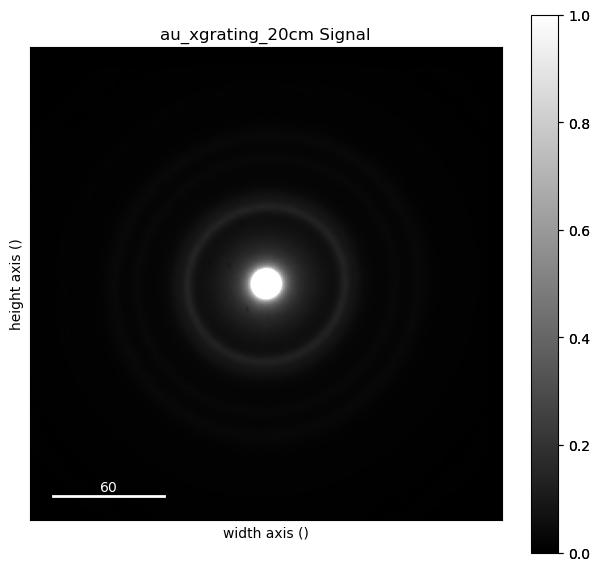

In [2]:
au_dpeg = hs.load('./data/03/au_xgrating_20cm.tif')
au_dpeg.plot(vmax=1)

Load a VDF image of Au X-grating for scan pixel calibration

/Users/carterfrancis/mambaforge/envs/pyxem-demos/lib/python3.11/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/Users/carterfrancis/mambaforge/envs/pyxem-demos/lib/python3.11/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


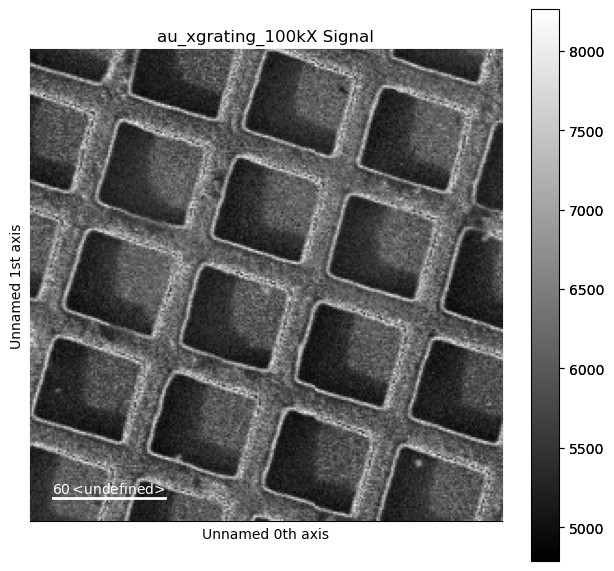

In [3]:
au_im = hs.load('./data/03/au_xgrating_100kX.hspy')
au_im.plot()

Load spatially averaged diffraction pattern from MoO3 standard for rotation calibration

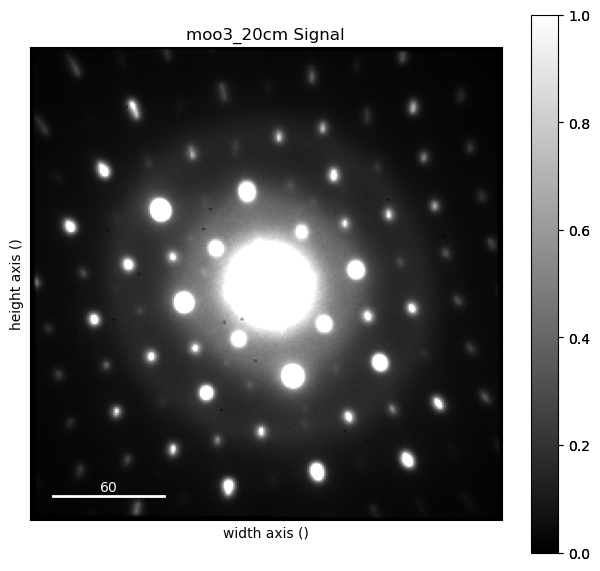

In [4]:
moo3_dpeg = hs.load('./data/03/moo3_20cm.tif')
moo3_dpeg.plot(vmax=1)

Load a VDF image of MoO3 standard for rotation calibration

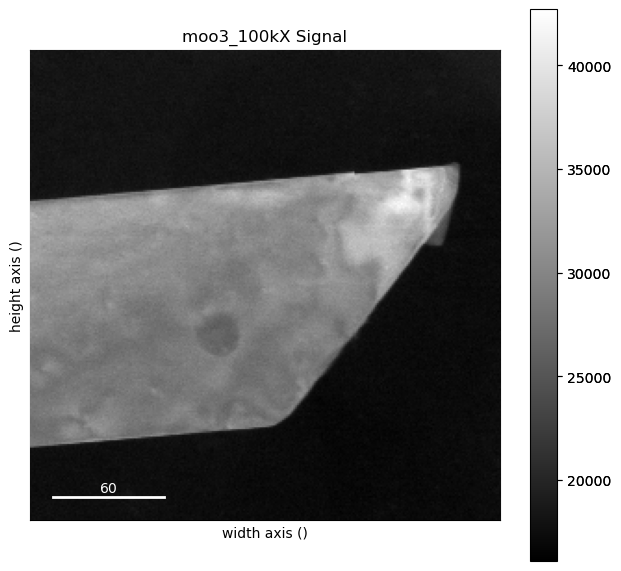

In [5]:
moo3_im = hs.load('./data/03/moo3_100kX.tif')
moo3_im.plot()

Initialise a CalibrationGenerator with the CalibrationDataLibrary

In [6]:
#Calibration Standard can only be gold for now
cal = CalibrationGenerator(diffraction_pattern=au_dpeg,
                           grating_image=au_im)

<a id='ids'></a>

##  2. Determine Lens Distortions

Lens distortions are assumed to be dominated by elliptical distortion due to the projector lens system. See, for example: https://www.sciencedirect.com/science/article/pii/S0304399105001087?via%3Dihub

Distortion correction is based on measuring the ellipticity of a ring pattern obtained from an Au X-grating calibration standard in scaninng mode.

Determine distortion correction matrix by ring fitting

In [7]:
cal.get_elliptical_distortion(mask_radius=10,
                              scale=100, amplitude=1000,
                              asymmetry=0.9,spread=2)

array([[0.97578103, 0.015497  , 0.        ],
       [0.015497  , 0.99008393, 0.        ],
       [0.        , 0.        , 1.        ]])

Obtain residuals before and after distortion correction and plot to inspect, the aim is for any differences to be small and circularly symmetric

[########################################] | 100% Completed | 104.62 ms
[########################################] | 100% Completed | 104.55 ms
[########################################] | 100% Completed | 106.63 ms


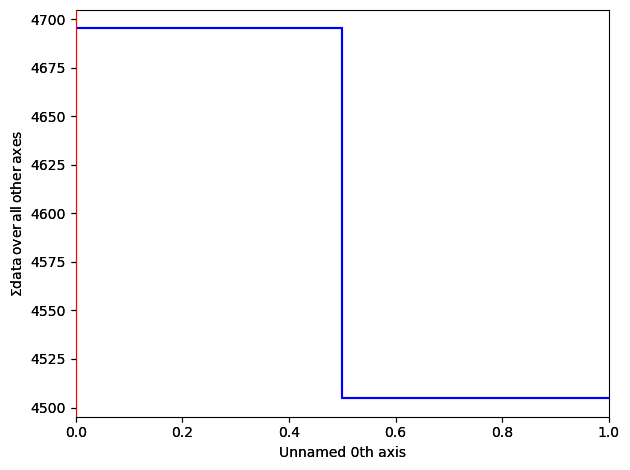

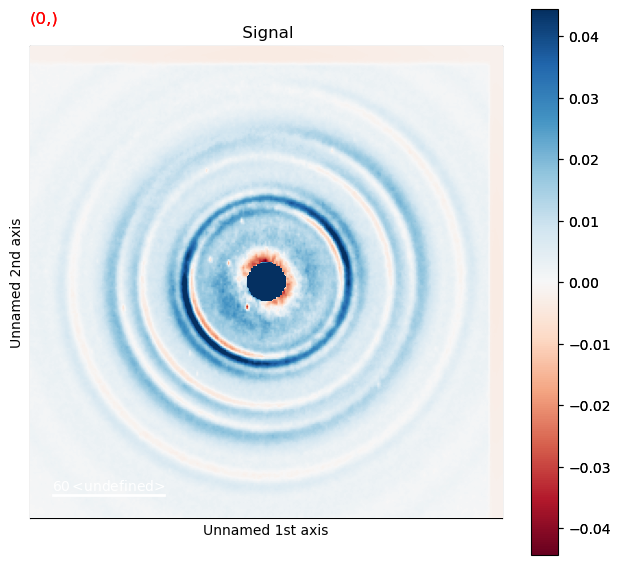

In [8]:
residuals = cal.get_distortion_residuals(mask_radius=10, spread=2)
residuals.plot(cmap='RdBu', vmax=0.04)

Plot distortion corrected diffraction pattern with adjustable reference circle for inspection

[########################################] | 100% Completed | 106.48 ms
[########################################] | 100% Completed | 103.43 ms


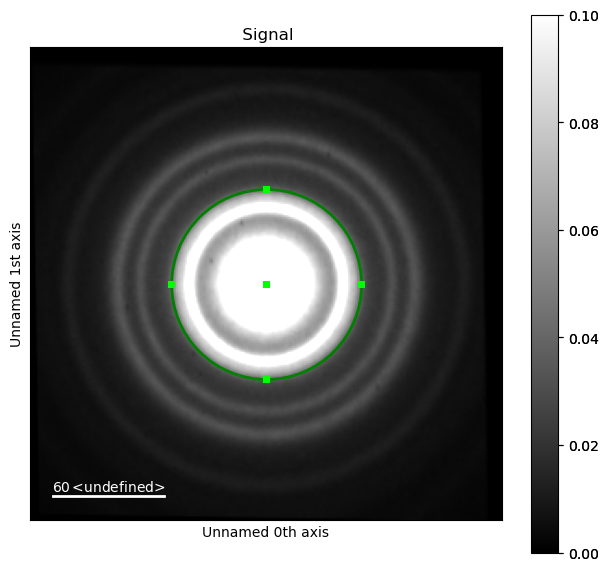

In [9]:
cal.plot_corrected_diffraction_pattern(vmax=0.1)

Check the affine matrix, which may be applied to other data

In [10]:
cal.affine_matrix

array([[0.97578103, 0.015497  , 0.        ],
       [0.015497  , 0.99008393, 0.        ],
       [0.        , 0.        , 1.        ]])

Inspect the ring fitting parameters

In [11]:
cal.ring_params

array([ 9.79693393e+01,  8.91327941e-02,  3.06389735e+00,  6.32494180e+02,
        9.32895126e-01, -4.14316780e+00])

Calculate correction matrix and confirm that in this case it is equal to the affine matrix

In [12]:
cal.get_correction_matrix()

array([[0.97578103, 0.015497  , 0.        ],
       [0.015497  , 0.99008393, 0.        ],
       [0.        , 0.        , 1.        ]])

<a href='#cal'></a>

##  3. Determining Real & Reciprocal Space Scales

Determine the diffraction pattern calibration in reciprocal Angstroms per pixel

In [13]:
cal.get_diffraction_calibration(mask_length=30,
                                linewidth=5)

[########################################] | 100% Completed | 102.92 ms
[########################################] | 100% Completed | 106.57 ms
[########################################] | 100% Completed | 114.26 ms
[########################################] | 100% Completed | 104.65 ms


0.010236557479496549

Plot the calibrated diffraction data to check it looks about right

[########################################] | 100% Completed | 106.15 ms
[########################################] | 100% Completed | 106.70 ms


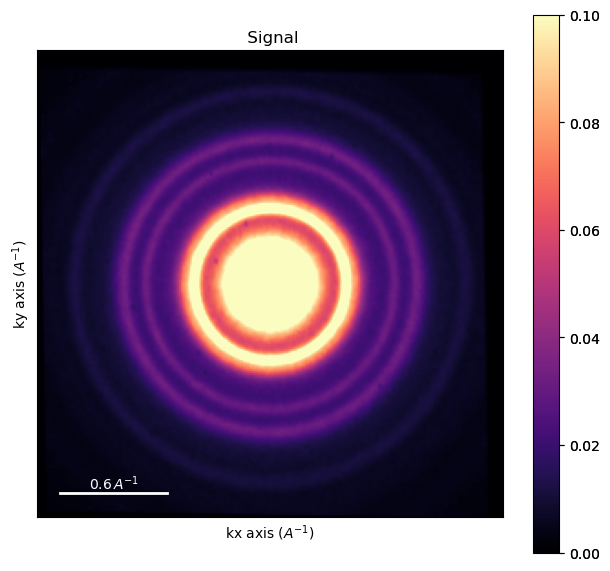

In [14]:
cal.plot_calibrated_data(data_to_plot='au_x_grating_dp',
                         cmap='magma', vmax=0.1)

Plot the cross grating image data to define the line along which to take trace

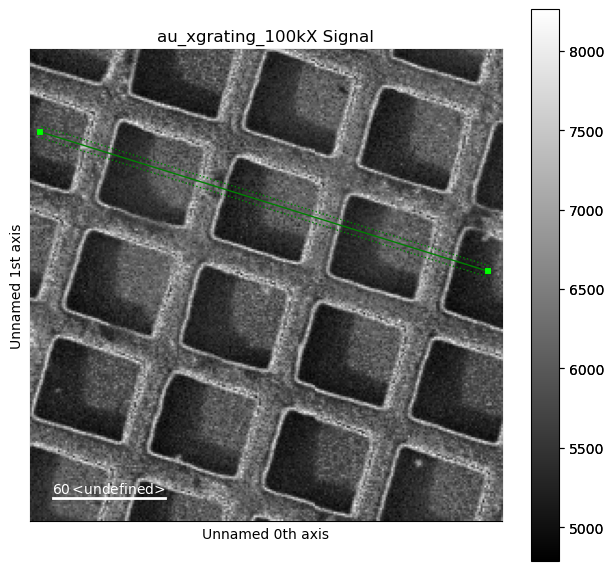

In [15]:
cal.grating_image.plot()
line = hs.roi.Line2DROI(x1=4.83957, y1=44.4148, x2=246.46, y2=119.159, linewidth=5.57199)
line.add_widget(cal.grating_image)

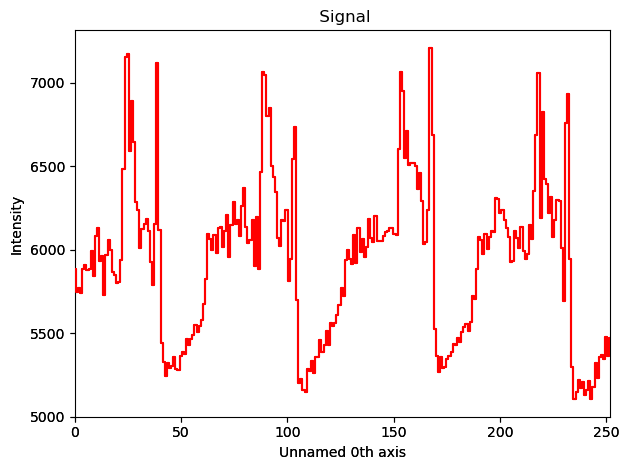

In [16]:
trace = line(cal.grating_image)
trace = trace.as_signal1D(spectral_axis=0)
trace.plot()

Obtain the navigation calibration from the trace

In [17]:
cal.get_navigation_calibration(line_roi=line, x1=40.,x2=232.,
                               n=3, xspace=500.)

[########################################] | 100% Completed | 115.00 ms


7.888195400350488